# Analyza nejistot minimalizace EMM

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

Nejprve načtu histogramy odpovídající jednotlivým měřením

In [2]:
import numpy as np


fotkor_z = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,1]
voltages_z = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")[1,:]
fotkor_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,5]
voltages_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")[5,:]

# pomocne promene
fotkor_z_shape = np.shape(fotkor_z)
fotkor_xz_shape = np.shape(fotkor_xz)
# dale predpokladam, ze signaly maji stejny pocet binu
# fotkor_shape = np.array( [fotkor_z_shape, fotkor_xz_shape] )

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale_z = np.array( range(0,fotkor_z_shape[0]) ) *t_res
t_scale_xz = np.array( range(0,fotkor_xz_shape[0]) ) *t_res

t_scale = t_scale_z


#---------- odecet pozadi
# spolecne vsem merenim
background_photocounts = 400 # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
bg_ph_sum = background_photocounts * t_measure  # celkovy pocet fotonu pozadi za cas mereni
#

last_bin_ratio_z = fotkor_z[fotkor_z_shape[0]-2] / fotkor_z[fotkor_z_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_z = bg_ph_sum/(fotkor_z_shape[0]-2 + last_bin_ratio_z)
last_bin_ratio_xz = fotkor_xz[fotkor_xz_shape[0]-2] / fotkor_xz[fotkor_xz_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_xz = bg_ph_sum/(fotkor_xz_shape[0]-2 + last_bin_ratio_xz)

fotkor_z[:fotkor_z_shape[0]-2] = fotkor_z[:fotkor_z_shape[0]-2] - bg_ph_per_bin_z 
fotkor_z[fotkor_z_shape[0]-2] = fotkor_z[fotkor_z_shape[0]-2] - bg_ph_per_bin_z * last_bin_ratio_z
fotkor_xz[:fotkor_xz_shape[0]-2] = fotkor_xz[:fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz 
fotkor_xz[fotkor_xz_shape[0]-2] = fotkor_xz[fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz * last_bin_ratio_xz
# ------------------------------

# vlozim signaly a voltage do matic
fotkor = np.transpose( np.array( [fotkor_z, fotkor_xz] ) ) # tvar: [data, osa]
voltages = np.transpose( np.array( [voltages_z, voltages_xz] ) ) # tvar: [data, osa]

fotkor_shape = np.shape(fotkor)

In [3]:
# odhad periody triggeru
Omega = np.zeros(fotkor_shape[1])
Omega_sigma = np.zeros(fotkor_shape[1])

for i in range(fotkor_shape[1]):
    T_trig = ( fotkor[fotkor_shape[0]-2,i] / fotkor[fotkor_shape[0]-3,i] )* t_res + t_scale[fotkor_shape[0]-2]
    T_trig_sigma = t_res
    # frekvence buzeni pasti

    drive_freq = 1/T_trig
    drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
    Omega[i] = 2*np.pi * drive_freq
    Omega_sigma[i] = 2*np.pi * drive_freq_sigma
    print(drive_freq)
    
Omega = np.mean(Omega)
Omega_sigma = np.sqrt(0.5*np.sum(Omega_sigma**2) )

print(Omega/(2*np.pi))
print(Omega_sigma/(2*np.pi))

30032035.976450287
30032822.857731443
30032429.417090867
230898.38519217444


Fitovani histogramu

In [40]:
# residua vcetne vah
def likehood_transform(x, Omega, S, time_step, sigma):
    # definuju funkci vracejici logaritmus pravdepodobnosti, ze z distrubuce dane sinusovkou, co fituji vyberu pozorovane body
    # predpokladam, ze kazdy bod je normalne rozdelen kolem sinusovky
    
    len_S = len(S)
    #print(len_S)
    S_fit = x[0]*( 1 + x[1] * np.cos( Omega * time_step * np.arange(0, len_S) + x[2] ) )
    
    sum_term = ( (S - S_fit )/sigma )**2
    log_term = np.log( np.ones(len_S) * sigma * np.sqrt(2*np.pi) )
    
    return( 0.5* np.sum( sum_term ) + np.sum(log_term) ) # vraci -log( likehood)

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

In [140]:
from scipy.optimize import minimize
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []
fot_phi = []

hist_sigma = [86,110] # sigma binu jednotlivych fotkor-signalu

for i in range(fotkor_shape[1]):
    
    # -----
    #podminky urcujici prijimuti reseni
    max_phi_unc = 0.3
    phi0 = 1.5
    
    #--- zde budu zkouset postupne ruzne pocatecni body tak, aby minimalizace vybrala globalni minimum
    x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
    -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), phi0]
    
    fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 )
    print(fit)
    print('\n')
    if ( np.sqrt(fit.hess_inv[2,2]) > max_phi_unc ) or (fit.x[1] < 0):
        x0 = [fotkor[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor[:fotkor_shape[0]-2,i].max()
        -fotkor[:fotkor_shape[0]-2,i].min() )/fotkor[:fotkor_shape[0]-2,i].mean(), -phi0]
    
        fit = minimize(likehood_transform, x0, args=(Omega, fotkor[:fotkor_shape[0]-2,i], t_res, hist_sigma[i] ), tol=1e-10 )
        print(fit)
        print('\n')
        
    #---- odhad nejistot parametru----
#     C = fit.hess_inv  # variancni-kovariancni matice
    C = fit.hess_inv
    #------------------------------- 
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]  )
    
    #---- faze fot-kor signalu
    fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    
    #---- sigma delta s ku s
    Delta_S_S_ratio_sigma.append(np.sqrt( C[1,1]) )
    
S_0 = x[0,:]  # parametry S_0
DeltaS = x[1,:] * S_0 # delta S

      fun: 767.7988848421435
 hess_inv: array([[ 3.49335043e-01,  0.00000000e+00, -4.32020486e-02],
       [ 0.00000000e+00,  6.82075552e-09, -7.88713805e-09],
       [-4.32020486e-02, -7.88713805e-09,  1.47441887e-02]])
      jac: array([0.00000000e+00, 2.28881836e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 226
      nit: 15
     njev: 45
   status: 2
  success: False
        x: array([ 6.66192742e+03, -1.04124311e-02,  1.71404598e+00])


      fun: 767.798884842005
 hess_inv: array([[ 3.49939138e-02, -6.98549893e-06, -3.43216646e-02],
       [-6.98549893e-06,  2.51653782e-06,  9.28029048e-06],
       [-3.43216646e-02,  9.28029048e-06,  3.57889776e-02]])
      jac: array([7.62939453e-06, 1.52587891e-05, 7.62939453e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 542
      nit: 16
     njev: 106
   status: 2
  success: False
        x: array([ 6.66192757e+03,  1.04124161e-02, -1.4

In [142]:
print(DeltaS_S_ratio)
print(Delta_S_S_ratio_sigma)
print(fot_phi)
print(sigmas[2,:])

[0.010412416097451605, 0.010197627439354094]
[0.001586359927480201, 0.002039634817467594]
[-1.427546505824729, 1.3412538473502291]
[0.18917975 0.1977702 ]


priblizne odpovida random samplingu -> vizualni kontrola

In [143]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

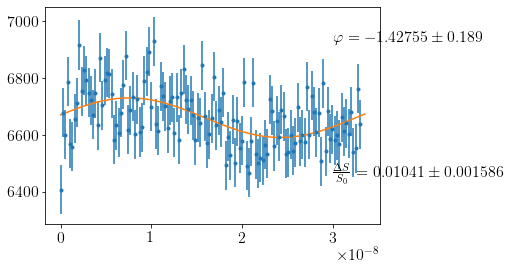

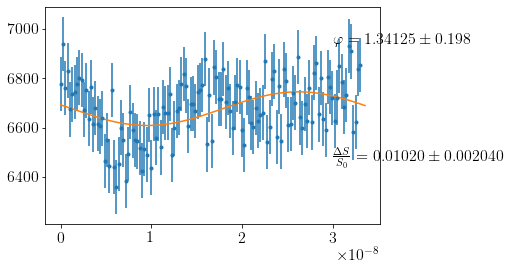

In [144]:
# plot fitu vcetne errorbaru
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func( [S_0[i],DeltaS[i],x[2,i]], Omega, time_fit)
    
    plt.figure()
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=hist_sigma[i],fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(DeltaS_S_ratio[i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor[:,i].max()-500,text) 
    text2 = r'$\varphi  = {:.5f} \pm {:.3}$'.format(fot_phi[i], sigmas[2,i])
    plt.text(3e-8, fotkor[:,i].max(),text2) 


ok

## Max. likehood test

likehood fce vypada ok. zkusim minimalizovat

test vypada ok